In [1]:
from __future__ import print_function
import librosa

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
samples_per_chunk = 300
num_chunks_per_slice = 11
num_chunks_per_beat = 8

In [4]:
filename = "song.ogg"

In [5]:
y, sr = librosa.load(filename)

In [6]:
y

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [7]:
len(y)

5006112

In [8]:
#plt.plot(range(len(y)),y)

In [9]:
length = librosa.get_duration(y=y,sr=sr)

In [10]:
tempo = np.round(librosa.beat.tempo(y, sr=sr))
new_sample_rate = (tempo/200)*8000
y = librosa.resample(y, sr, new_sample_rate)

/nfshome/apps/python-3.6.7/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


In [11]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [12]:
#This function takes an int representing the BPM, a float representing how long the song is in secs, and
#a long int representing the file size. This information is used to create a list containing the start 
#and endpoints for blocks.

def blockList(BPM, secs, fileSize,y):
    mins = secs / 60.0 #how many minutes long is the song
    numBeats = int(BPM * mins) #the number of beats in the song
    numChunks = numBeats * 8 #the total number of chunks
    chunkSize = int(fileSize / numChunks) #how many points there are in a chunk

    chunker = chunks(y, int(chunkSize))
    List = [np.abs(np.fft.fft(next(chunker)))[0:int(chunkSize/2)+1] for i in range(int(numChunks))]

    print("minutes   :", mins)
    print("num beats :", numBeats)
    print("num chunks:", numChunks)
    print("chunk size:", chunkSize)        
    
    return List, numChunks, numBeats
    

In [31]:
chunkedList, number_of_chunks, number_of_beats = blockList(tempo, length, len(y), y)

minutes   : 3.7839092970521544
num beats : 514
num chunks: 4112
chunk size: 300


In [32]:
print(samples_per_chunk)

300


In [75]:
def sliding_window_gen(l, noc, ncps): #parameters: the list of numpy arrays, the number of chunks, and the number of chunks per slice
    for i in range(int(ncps/2)): #pad both sides of the input list with numpy arrays of zeros 
        l.insert(0, np.zeros(int(samples_per_chunk/2)+1))
        l.append(np.zeros(int(samples_per_chunk/2)+1))
    for j in range(noc):
        yield np.concatenate(l[j:j+ncps])

In [76]:
window_generator = sliding_window_gen(chunkedList, number_of_chunks, num_chunks_per_slice)

In [77]:
current_window = np.zeros(shape=(number_of_chunks, int(((samples_per_chunk/2)+1)*num_chunks_per_slice)))
for i in range(number_of_chunks):
    current_window[i] = next(window_generator)

In [78]:
len(current_window)

In [79]:
import json
import numpy as np
from sympy import *
init_printing(use_latex=True)
import scipy.spatial.distance as ssd
from pprint import pprint
    
def jsonInterpretor(filename, beats):
    
    with open(filename) as f:
        data = json.load(f)          
  
    notes = "_notes"
    time = "_time"
    lineIndex = "_lineIndex" #row
    lineLayer = "_lineLayer" #column
    types = "_type" #0 is one color and 1 is the other
    cutDirection = "_cutDirection"#9 cut directions

    MatrixRows = beats * num_chunks_per_beat

    FinalMatrix = np.zeros(shape=(MatrixRows,32))#will hold all of the vectors, should be 32 by the number of beats * 8

    j = 0; #index for .json notes
    beat = 0.0 #1/8 increments for keeping track of time
    
    
    #data[notes][3][time]
    for i in range(MatrixRows):
        if np.round(data[notes][j][time]*num_chunks_per_beat)/num_chunks_per_beat == beat:
            if data[notes][j][types] == 0: #if the color is equal to 0, start at zero
                    FinalMatrix[i][data[notes][j][lineIndex]]+=1
                    FinalMatrix[i][data[notes][j][lineLayer]+4]+=1
                    FinalMatrix[i][data[notes][j][cutDirection]+7]+=1
            elif data[notes][i][types] == 1: #else the color is equal to 1, add 16
                    FinalMatrix[i][data[notes][j][lineIndex]+16]+=1
                    FinalMatrix[i][data[notes][j][lineLayer]+4+16]+=1
                    FinalMatrix[i][data[notes][j][cutDirection]+7+16]+=1
            j+=1#increment the note cntr after updating the matrix with the appropriate ones
        beat +=.125#increment the beat cntr after every 'i' increment
    
    return FinalMatrix;



In [80]:
A = jsonInterpretor('Hard.json', number_of_beats)
def beatmap_training_gen(A): #slice matrix into its rows
    for i in range(len(A)):
        yield A[i:(i+1)]

In [81]:
beatmap_training_generator = beatmap_training_gen(A)

In [82]:
next(beatmap_training_generator)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [83]:
import keras

from IPython.display import SVG
from IPython.display import display
from keras.utils.vis_utils import model_to_dot

from sympy import *
init_printing(use_latex=True)

model = keras.models.Sequential()
model.add(keras.layers.Dense(512,input_dim=(int((samples_per_chunk/2+1)*num_chunks_per_slice)),activation='relu', bias_initializer=keras.initializers.Constant(0.1)))
model.add(keras.layers.Dense(32,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam')
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               850944    
_________________________________________________________________
dense_10 (Dense)             (None, 32)                16416     
Total params: 867,360
Trainable params: 867,360
Non-trainable params: 0
_________________________________________________________________
None


In [86]:
#window size of 1. 
history = model.fit(current_window, A,
    batch_size=1,epochs=10,verbose=1)

Epoch 1/10
4112/4112 [==============================] - 251s 61ms/step - loss: 0.0037
Epoch 2/10
4112/4112 [==============================] - 237s 58ms/step - loss: 0.0022
Epoch 3/10
4112/4112 [==============================] - 206s 50ms/step - loss: 0.0022
Epoch 4/10
4112/4112 [==============================] - 211s 51ms/step - loss: 0.0022
Epoch 5/10
4112/4112 [==============================] - 224s 54ms/step - loss: 0.0022
Epoch 6/10
4112/4112 [==============================] - 213s 52ms/step - loss: 0.0022
Epoch 7/10
4112/4112 [==============================] - 204s 50ms/step - loss: 0.0022
Epoch 8/10
4112/4112 [==============================] - 230s 56ms/step - loss: 0.0022
Epoch 9/10
4112/4112 [==============================] - 201s 49ms/step - loss: 0.0022
Epoch 10/10
4112/4112 [==============================] - 236s 57ms/step - loss: 0.0022


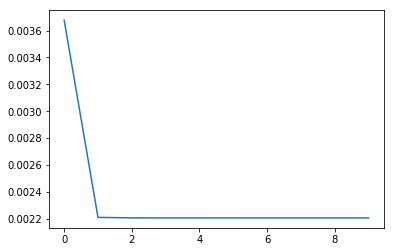

In [87]:
plt.plot(history.history['loss'])

In [94]:
score = model.evaluate(current_window, A, verbose=1)
print('Test loss:', score)

4112/4112 [==============================] - 2s 383us/step
Test loss: 0.0022049705650988172


In [95]:
output = model.predict(current_window, verbose=1)

4112/4112 [==============================] - 2s 434us/step


In [97]:
output

array([[8.1861472e-08, 7.9279630e-08, 8.4545455e-08, ..., 9.5125387e-08,
        9.4740436e-08, 8.6771230e-08],
       [8.1861472e-08, 7.9279630e-08, 8.4545455e-08, ..., 9.5125387e-08,
        9.4740436e-08, 8.6771230e-08],
       [8.1861472e-08, 7.9279630e-08, 8.4545455e-08, ..., 9.5125387e-08,
        9.4740436e-08, 8.6771230e-08],
       ...,
       [7.3007264e-08, 7.0999953e-08, 7.5543028e-08, ..., 8.3108738e-08,
        8.2232980e-08, 7.6293389e-08],
       [7.4939564e-08, 7.2808270e-08, 7.7532093e-08, ..., 8.5768328e-08,
        8.4931742e-08, 7.8627117e-08],
       [7.6164568e-08, 7.3935368e-08, 7.8733066e-08, ..., 8.7336765e-08,
        8.6594149e-08, 7.9971862e-08]], dtype=float32)